In this notebook, we'll be controlling the inverted pendulum using DoMPC. again we will be able to apply a rotational force (torque) at the pivot point


$$
Lm\theta(t)'' = -mg \sin(\theta(t)) -kL\theta(t)' + \tau
$$
where 
 - $L$ is the length of the rod (massless)
 - $m$ is the mass of the blob at the end
 - $\theta$ is the angle
 - $k$ is the coefficient of friction
 - $g$ is gravitational constant
 
In state space form the equations look like this:
    
$$
\dot x_1(t) = x_2(t) \\
\dot x_2(t) = -\frac{g}{L} \sin(x_1(t)) -\frac{k}{m}x_2(t) + \frac{1}{m}\tau
$$

In [49]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
import do_mpc
from casadi import *
from matplotlib.animation import FuncAnimation

%matplotlib notebook

# Forward simulation

In [50]:
# Defining the constants
g = 9.8
l = 1
m = 1
k = 1

In [51]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

phi = model.set_variable(var_type='_x', var_name='phi', shape=(2,1))
friction = model.set_variable(var_type='_tvp', var_name='friction', shape=(1, 1))
tau = model.set_variable(var_type='_u', var_name='tau', shape=(1,1))

phi_next = vertcat(phi[1], -g/l*np.sin(phi[0]) - friction/m*phi[1] + 1/m*tau)

model.set_rhs('phi', phi_next)
model.setup()

In [52]:
params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 0.01
}

simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(**params_simulator)

# Set the time varying parameter
tvp_template = simulator.get_tvp_template()
def tvp_fun(t_now):
    if t_now < 5:
        tvp_template['friction'] = 0
    else:
        tvp_template['friction'] = 1
    return tvp_template
simulator.set_tvp_fun(tvp_fun)

simulator.setup()

In [53]:
init_vel = 0
simulator.x0 = np.array([140*np.pi/180,init_vel])

In [54]:
u0 = np.zeros((1,1))*0
for i in range(1500):
    simulator.make_step(u0)

<IPython.core.display.Javascript object>


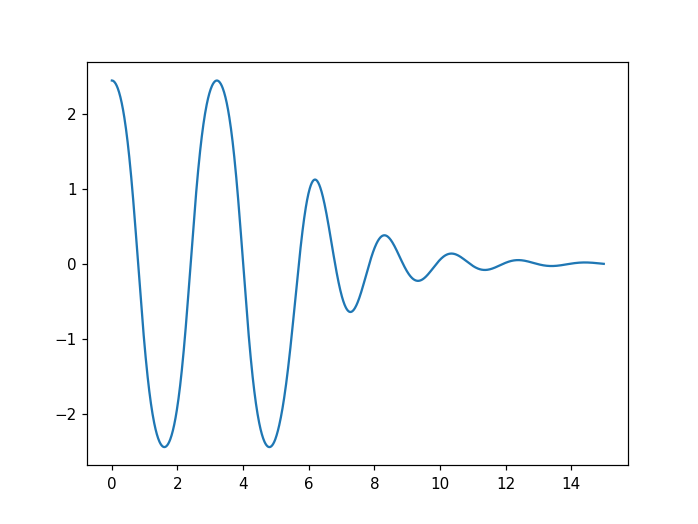

In [55]:
phases_sim = simulator.data['_x'][:,0]
angle_sim = np.arctan2(np.sin(phases_sim), np.cos(phases_sim))
plt.plot(simulator.data['_time'],angle_sim)

<IPython.core.display.Javascript object>


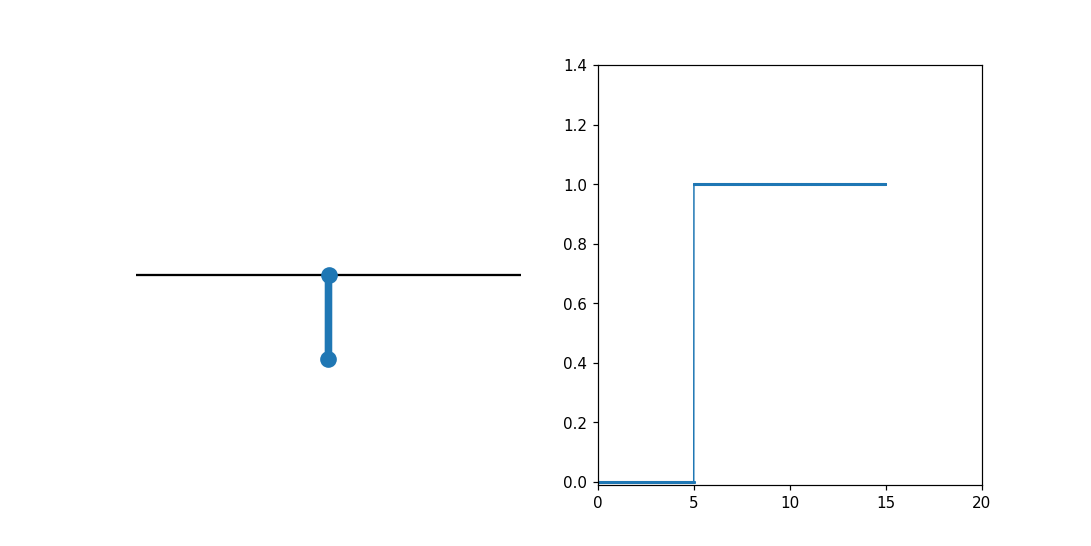

In [74]:
def _pendulum_with_mass(x, L1):
    x = x.flatten()
    # Get the x,y coordinates of the two bars for the given state x.
    line_1_x = np.array([0,L1 * np.sin(x[0])])
    line_1_y = np.array([0,-L1 * np.cos(x[0])])
    line_1 = np.stack((line_1_x, line_1_y))
    return line_1

def animate_(simulator,save,name):
    
    # The function describing the gif:
    time = simulator.data['_time'].flatten()
    x_arr = simulator.data._x
    u_arr = simulator.data._u
    friction = simulator.data._tvp.flatten()
    
    
    fig,ax = plt.subplots(1,2,figsize=(10, 5))
    # First axis
    ax[0].axhline(0, color='black')
    bar1 = ax[0].plot([], [], '-o', linewidth=5, markersize=10)
    ax[0].set_xlim(-2.5, 2.5)
    ax[0].set_ylim(-2.5, 2.5)
    ax[0].set_axis_off()
    
    
    data1 = ax[1].plot([], [], '-o', linewidth=1, markersize=1)
    ax[1].set_xlim(-0.01, 20)
    ax[1].set_ylim(-0.01, 1.4)
    #x[0].align_ylabels()
    #x[0].tight_layout()
    


    def update(t_ind):
        line1 = _pendulum_with_mass(x_arr[t_ind],l)
        bar1[0].set_data(line1[0], line1[1])
        
        data1[0].set_data(time[0:t_ind], friction[0:t_ind])
              

    anim = FuncAnimation(fig, update, frames=len(x_arr), repeat=False, interval=10)
    if save:
        anim.save(name + '_animation.gif', writer='pillow', fps=100)
    else:
        plt.show()
    return anim

animation = animate_(simulator,False,'')

# Now trying to reverse engineer the friction coefficient using a PINN

In [57]:
import numpy as np
from torch import nn
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt
import itertools

In [58]:
class Pendulum_approximator(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh(),l1_init = 0.1):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
        
        # Register the other paramter
        #self.l1 = nn.Parameter(torch.tensor([l1_init], requires_grad=True).float())
        #self.register_parameter("l1",self.l1)
    
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out
    
PINN = Pendulum_approximator(2,2)

In [59]:
class Friction_approximator(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh()):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out
    
Fapprox = Friction_approximator(2,3)

In [60]:
# This is the forward function
def f(nn, x):
    return nn(x)

# This is the forward derivative function
def df(nn,x,order = 1):
    df_value = f(nn,x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs = torch.ones_like(x),
            create_graph = True,
            retain_graph = True
        )[0]
    return df_value

In [61]:
def compute_loss(nn,rr,x,t_data,f_data):
    de_loss = m*l*df(nn,x,2) - (-m*g*torch.sin(nn(x)) - rr(x)*l*df(nn,x,1))
    bc_loss = f(nn,t_data) - f_data.view(-1,1)
    ic_loss = df(nn,torch.tensor([[0.0]],requires_grad = True),1) - init_vel
    final_loss = de_loss.pow(2).mean()+ bc_loss.pow(2).mean() + ic_loss.pow(2).mean()
    return final_loss

In [62]:
def optimise(optimiser,nn,rr,t_col,t_data,f_data):
    optimiser.zero_grad()
    loss = compute_loss(nn,rr,t_col,t_data,f_data)
    loss.backward()
    optimiser.step()
    return loss


In [63]:
lr = 0.01
epochs = 200000
PINN = Pendulum_approximator(2,10)
F_approx = Friction_approximator(2,3)
learnable_params = list(PINN.parameters())  + list(F_approx.parameters())
pi_optimizer = Adam(learnable_params, lr=lr)

In [64]:
t_boundary = torch.from_numpy(simulator.data['_time']).float()
f_boundary = torch.from_numpy(simulator.data['_x'][:,0]).float()
t_collocation =  t_boundary
t_collocation.requires_grad = True

In [65]:
t_boundary.size()[0]

1500

In [70]:
batch_size = 32
loss_vector = []
iteration_vector =[]
for i in range(10000):
    print(f"Epoch {i}")
    permutation = torch.randperm(t_boundary.size()[0])
    for j in range(0,t_boundary.size()[0],batch_size):
        indices = permutation[j:j+batch_size]
        loss = optimise(pi_optimizer,PINN,F_approx,t_collocation[indices],t_boundary[indices],f_boundary[indices])
    iteration_vector.append(i)
    loss_vector.append(loss.detach().numpy())

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110


Epoch 831
Epoch 832
Epoch 833
Epoch 834
Epoch 835
Epoch 836
Epoch 837
Epoch 838
Epoch 839
Epoch 840
Epoch 841
Epoch 842
Epoch 843
Epoch 844
Epoch 845
Epoch 846
Epoch 847
Epoch 848
Epoch 849
Epoch 850
Epoch 851
Epoch 852
Epoch 853
Epoch 854
Epoch 855
Epoch 856
Epoch 857
Epoch 858
Epoch 859
Epoch 860
Epoch 861
Epoch 862
Epoch 863
Epoch 864
Epoch 865
Epoch 866
Epoch 867
Epoch 868
Epoch 869
Epoch 870
Epoch 871
Epoch 872
Epoch 873
Epoch 874
Epoch 875
Epoch 876
Epoch 877
Epoch 878
Epoch 879
Epoch 880
Epoch 881
Epoch 882
Epoch 883
Epoch 884
Epoch 885
Epoch 886
Epoch 887
Epoch 888
Epoch 889
Epoch 890
Epoch 891
Epoch 892
Epoch 893
Epoch 894
Epoch 895
Epoch 896
Epoch 897
Epoch 898
Epoch 899
Epoch 900
Epoch 901
Epoch 902
Epoch 903
Epoch 904
Epoch 905
Epoch 906
Epoch 907
Epoch 908
Epoch 909
Epoch 910
Epoch 911
Epoch 912
Epoch 913
Epoch 914
Epoch 915
Epoch 916
Epoch 917
Epoch 918
Epoch 919
Epoch 920
Epoch 921
Epoch 922
Epoch 923
Epoch 924
Epoch 925
Epoch 926
Epoch 927
Epoch 928
Epoch 929
Epoch 930


Epoch 1592
Epoch 1593
Epoch 1594
Epoch 1595
Epoch 1596
Epoch 1597
Epoch 1598
Epoch 1599
Epoch 1600
Epoch 1601
Epoch 1602
Epoch 1603
Epoch 1604
Epoch 1605
Epoch 1606
Epoch 1607
Epoch 1608
Epoch 1609
Epoch 1610
Epoch 1611
Epoch 1612
Epoch 1613
Epoch 1614
Epoch 1615
Epoch 1616
Epoch 1617
Epoch 1618
Epoch 1619
Epoch 1620
Epoch 1621
Epoch 1622
Epoch 1623
Epoch 1624
Epoch 1625
Epoch 1626
Epoch 1627
Epoch 1628
Epoch 1629
Epoch 1630
Epoch 1631
Epoch 1632
Epoch 1633
Epoch 1634
Epoch 1635
Epoch 1636
Epoch 1637
Epoch 1638
Epoch 1639
Epoch 1640
Epoch 1641
Epoch 1642
Epoch 1643
Epoch 1644
Epoch 1645
Epoch 1646
Epoch 1647
Epoch 1648
Epoch 1649
Epoch 1650
Epoch 1651
Epoch 1652
Epoch 1653
Epoch 1654
Epoch 1655
Epoch 1656
Epoch 1657
Epoch 1658
Epoch 1659
Epoch 1660
Epoch 1661
Epoch 1662
Epoch 1663
Epoch 1664
Epoch 1665
Epoch 1666
Epoch 1667
Epoch 1668
Epoch 1669
Epoch 1670
Epoch 1671
Epoch 1672
Epoch 1673
Epoch 1674
Epoch 1675
Epoch 1676
Epoch 1677
Epoch 1678
Epoch 1679
Epoch 1680
Epoch 1681
Epoch 1682

Epoch 2338
Epoch 2339
Epoch 2340
Epoch 2341
Epoch 2342
Epoch 2343
Epoch 2344
Epoch 2345
Epoch 2346
Epoch 2347
Epoch 2348
Epoch 2349
Epoch 2350
Epoch 2351
Epoch 2352
Epoch 2353
Epoch 2354
Epoch 2355
Epoch 2356
Epoch 2357
Epoch 2358
Epoch 2359
Epoch 2360
Epoch 2361
Epoch 2362
Epoch 2363
Epoch 2364
Epoch 2365
Epoch 2366
Epoch 2367
Epoch 2368
Epoch 2369
Epoch 2370
Epoch 2371
Epoch 2372
Epoch 2373
Epoch 2374
Epoch 2375
Epoch 2376
Epoch 2377
Epoch 2378
Epoch 2379
Epoch 2380
Epoch 2381
Epoch 2382
Epoch 2383
Epoch 2384
Epoch 2385
Epoch 2386
Epoch 2387
Epoch 2388
Epoch 2389
Epoch 2390
Epoch 2391
Epoch 2392
Epoch 2393
Epoch 2394
Epoch 2395
Epoch 2396
Epoch 2397
Epoch 2398
Epoch 2399
Epoch 2400
Epoch 2401
Epoch 2402
Epoch 2403
Epoch 2404
Epoch 2405
Epoch 2406
Epoch 2407
Epoch 2408
Epoch 2409
Epoch 2410
Epoch 2411
Epoch 2412
Epoch 2413
Epoch 2414
Epoch 2415
Epoch 2416
Epoch 2417
Epoch 2418
Epoch 2419
Epoch 2420
Epoch 2421
Epoch 2422
Epoch 2423
Epoch 2424
Epoch 2425
Epoch 2426
Epoch 2427
Epoch 2428

Epoch 3084
Epoch 3085
Epoch 3086
Epoch 3087
Epoch 3088
Epoch 3089
Epoch 3090
Epoch 3091
Epoch 3092
Epoch 3093
Epoch 3094
Epoch 3095
Epoch 3096
Epoch 3097
Epoch 3098
Epoch 3099
Epoch 3100
Epoch 3101
Epoch 3102
Epoch 3103
Epoch 3104
Epoch 3105
Epoch 3106
Epoch 3107
Epoch 3108
Epoch 3109
Epoch 3110
Epoch 3111
Epoch 3112
Epoch 3113
Epoch 3114
Epoch 3115
Epoch 3116
Epoch 3117
Epoch 3118
Epoch 3119
Epoch 3120
Epoch 3121
Epoch 3122
Epoch 3123
Epoch 3124
Epoch 3125
Epoch 3126
Epoch 3127
Epoch 3128
Epoch 3129
Epoch 3130
Epoch 3131
Epoch 3132
Epoch 3133
Epoch 3134
Epoch 3135
Epoch 3136
Epoch 3137
Epoch 3138
Epoch 3139
Epoch 3140
Epoch 3141
Epoch 3142
Epoch 3143
Epoch 3144
Epoch 3145
Epoch 3146
Epoch 3147
Epoch 3148
Epoch 3149
Epoch 3150
Epoch 3151
Epoch 3152
Epoch 3153
Epoch 3154
Epoch 3155
Epoch 3156
Epoch 3157
Epoch 3158
Epoch 3159
Epoch 3160
Epoch 3161
Epoch 3162
Epoch 3163
Epoch 3164
Epoch 3165
Epoch 3166
Epoch 3167
Epoch 3168
Epoch 3169
Epoch 3170
Epoch 3171
Epoch 3172
Epoch 3173
Epoch 3174

Epoch 3830
Epoch 3831
Epoch 3832
Epoch 3833
Epoch 3834
Epoch 3835
Epoch 3836
Epoch 3837
Epoch 3838
Epoch 3839
Epoch 3840
Epoch 3841
Epoch 3842
Epoch 3843
Epoch 3844
Epoch 3845
Epoch 3846
Epoch 3847
Epoch 3848
Epoch 3849
Epoch 3850
Epoch 3851
Epoch 3852
Epoch 3853
Epoch 3854
Epoch 3855
Epoch 3856
Epoch 3857
Epoch 3858
Epoch 3859
Epoch 3860
Epoch 3861
Epoch 3862
Epoch 3863
Epoch 3864
Epoch 3865
Epoch 3866
Epoch 3867
Epoch 3868
Epoch 3869
Epoch 3870
Epoch 3871
Epoch 3872
Epoch 3873
Epoch 3874
Epoch 3875
Epoch 3876
Epoch 3877
Epoch 3878
Epoch 3879
Epoch 3880
Epoch 3881
Epoch 3882
Epoch 3883
Epoch 3884
Epoch 3885
Epoch 3886
Epoch 3887
Epoch 3888
Epoch 3889
Epoch 3890
Epoch 3891
Epoch 3892
Epoch 3893
Epoch 3894
Epoch 3895
Epoch 3896
Epoch 3897
Epoch 3898
Epoch 3899
Epoch 3900
Epoch 3901
Epoch 3902
Epoch 3903
Epoch 3904
Epoch 3905
Epoch 3906
Epoch 3907
Epoch 3908
Epoch 3909
Epoch 3910
Epoch 3911
Epoch 3912
Epoch 3913
Epoch 3914
Epoch 3915
Epoch 3916
Epoch 3917
Epoch 3918
Epoch 3919
Epoch 3920

Epoch 4576
Epoch 4577
Epoch 4578
Epoch 4579
Epoch 4580
Epoch 4581
Epoch 4582
Epoch 4583
Epoch 4584
Epoch 4585
Epoch 4586
Epoch 4587
Epoch 4588
Epoch 4589
Epoch 4590
Epoch 4591
Epoch 4592
Epoch 4593
Epoch 4594
Epoch 4595
Epoch 4596
Epoch 4597
Epoch 4598
Epoch 4599
Epoch 4600
Epoch 4601
Epoch 4602
Epoch 4603
Epoch 4604
Epoch 4605
Epoch 4606
Epoch 4607
Epoch 4608
Epoch 4609
Epoch 4610
Epoch 4611
Epoch 4612
Epoch 4613
Epoch 4614
Epoch 4615
Epoch 4616
Epoch 4617
Epoch 4618
Epoch 4619
Epoch 4620
Epoch 4621
Epoch 4622
Epoch 4623
Epoch 4624
Epoch 4625
Epoch 4626
Epoch 4627
Epoch 4628
Epoch 4629
Epoch 4630
Epoch 4631
Epoch 4632
Epoch 4633
Epoch 4634
Epoch 4635
Epoch 4636
Epoch 4637
Epoch 4638
Epoch 4639
Epoch 4640
Epoch 4641
Epoch 4642
Epoch 4643
Epoch 4644
Epoch 4645
Epoch 4646
Epoch 4647
Epoch 4648
Epoch 4649
Epoch 4650
Epoch 4651
Epoch 4652
Epoch 4653
Epoch 4654
Epoch 4655
Epoch 4656
Epoch 4657
Epoch 4658
Epoch 4659
Epoch 4660
Epoch 4661
Epoch 4662
Epoch 4663
Epoch 4664
Epoch 4665
Epoch 4666

Epoch 5322
Epoch 5323
Epoch 5324
Epoch 5325
Epoch 5326
Epoch 5327
Epoch 5328
Epoch 5329
Epoch 5330
Epoch 5331
Epoch 5332
Epoch 5333
Epoch 5334
Epoch 5335
Epoch 5336
Epoch 5337
Epoch 5338
Epoch 5339
Epoch 5340
Epoch 5341
Epoch 5342
Epoch 5343
Epoch 5344
Epoch 5345
Epoch 5346
Epoch 5347
Epoch 5348
Epoch 5349
Epoch 5350
Epoch 5351
Epoch 5352
Epoch 5353
Epoch 5354
Epoch 5355
Epoch 5356
Epoch 5357
Epoch 5358
Epoch 5359
Epoch 5360
Epoch 5361
Epoch 5362
Epoch 5363
Epoch 5364
Epoch 5365
Epoch 5366
Epoch 5367
Epoch 5368
Epoch 5369
Epoch 5370
Epoch 5371
Epoch 5372
Epoch 5373
Epoch 5374
Epoch 5375
Epoch 5376
Epoch 5377
Epoch 5378
Epoch 5379
Epoch 5380
Epoch 5381
Epoch 5382
Epoch 5383
Epoch 5384
Epoch 5385
Epoch 5386
Epoch 5387
Epoch 5388
Epoch 5389
Epoch 5390
Epoch 5391
Epoch 5392
Epoch 5393
Epoch 5394
Epoch 5395
Epoch 5396
Epoch 5397
Epoch 5398
Epoch 5399
Epoch 5400
Epoch 5401
Epoch 5402
Epoch 5403
Epoch 5404
Epoch 5405
Epoch 5406
Epoch 5407
Epoch 5408
Epoch 5409
Epoch 5410
Epoch 5411
Epoch 5412

Epoch 6068
Epoch 6069
Epoch 6070
Epoch 6071
Epoch 6072
Epoch 6073
Epoch 6074
Epoch 6075
Epoch 6076
Epoch 6077
Epoch 6078
Epoch 6079
Epoch 6080
Epoch 6081
Epoch 6082
Epoch 6083
Epoch 6084
Epoch 6085
Epoch 6086
Epoch 6087
Epoch 6088
Epoch 6089
Epoch 6090
Epoch 6091
Epoch 6092
Epoch 6093
Epoch 6094
Epoch 6095
Epoch 6096
Epoch 6097
Epoch 6098
Epoch 6099
Epoch 6100
Epoch 6101
Epoch 6102
Epoch 6103
Epoch 6104
Epoch 6105
Epoch 6106
Epoch 6107
Epoch 6108
Epoch 6109
Epoch 6110
Epoch 6111
Epoch 6112
Epoch 6113
Epoch 6114
Epoch 6115
Epoch 6116
Epoch 6117
Epoch 6118
Epoch 6119
Epoch 6120
Epoch 6121
Epoch 6122
Epoch 6123
Epoch 6124
Epoch 6125
Epoch 6126
Epoch 6127
Epoch 6128
Epoch 6129
Epoch 6130
Epoch 6131
Epoch 6132
Epoch 6133
Epoch 6134
Epoch 6135
Epoch 6136
Epoch 6137
Epoch 6138
Epoch 6139
Epoch 6140
Epoch 6141
Epoch 6142
Epoch 6143
Epoch 6144
Epoch 6145
Epoch 6146
Epoch 6147
Epoch 6148
Epoch 6149
Epoch 6150
Epoch 6151
Epoch 6152
Epoch 6153
Epoch 6154
Epoch 6155
Epoch 6156
Epoch 6157
Epoch 6158

Epoch 6814
Epoch 6815
Epoch 6816
Epoch 6817
Epoch 6818
Epoch 6819
Epoch 6820
Epoch 6821
Epoch 6822
Epoch 6823
Epoch 6824
Epoch 6825
Epoch 6826
Epoch 6827
Epoch 6828
Epoch 6829
Epoch 6830
Epoch 6831
Epoch 6832
Epoch 6833
Epoch 6834
Epoch 6835
Epoch 6836
Epoch 6837
Epoch 6838
Epoch 6839
Epoch 6840
Epoch 6841
Epoch 6842
Epoch 6843
Epoch 6844
Epoch 6845
Epoch 6846
Epoch 6847
Epoch 6848
Epoch 6849
Epoch 6850
Epoch 6851
Epoch 6852
Epoch 6853
Epoch 6854
Epoch 6855
Epoch 6856
Epoch 6857
Epoch 6858
Epoch 6859
Epoch 6860
Epoch 6861
Epoch 6862
Epoch 6863
Epoch 6864
Epoch 6865
Epoch 6866
Epoch 6867
Epoch 6868
Epoch 6869
Epoch 6870
Epoch 6871
Epoch 6872
Epoch 6873
Epoch 6874
Epoch 6875
Epoch 6876
Epoch 6877
Epoch 6878
Epoch 6879
Epoch 6880
Epoch 6881
Epoch 6882
Epoch 6883
Epoch 6884
Epoch 6885
Epoch 6886
Epoch 6887
Epoch 6888
Epoch 6889
Epoch 6890
Epoch 6891
Epoch 6892
Epoch 6893
Epoch 6894
Epoch 6895
Epoch 6896
Epoch 6897
Epoch 6898
Epoch 6899
Epoch 6900
Epoch 6901
Epoch 6902
Epoch 6903
Epoch 6904

Epoch 7560
Epoch 7561
Epoch 7562
Epoch 7563
Epoch 7564
Epoch 7565
Epoch 7566
Epoch 7567
Epoch 7568
Epoch 7569
Epoch 7570
Epoch 7571
Epoch 7572
Epoch 7573
Epoch 7574
Epoch 7575
Epoch 7576
Epoch 7577
Epoch 7578
Epoch 7579
Epoch 7580
Epoch 7581
Epoch 7582
Epoch 7583
Epoch 7584
Epoch 7585
Epoch 7586
Epoch 7587
Epoch 7588
Epoch 7589
Epoch 7590
Epoch 7591
Epoch 7592
Epoch 7593
Epoch 7594
Epoch 7595
Epoch 7596
Epoch 7597
Epoch 7598
Epoch 7599
Epoch 7600
Epoch 7601
Epoch 7602
Epoch 7603
Epoch 7604
Epoch 7605
Epoch 7606
Epoch 7607
Epoch 7608
Epoch 7609
Epoch 7610
Epoch 7611
Epoch 7612
Epoch 7613
Epoch 7614
Epoch 7615
Epoch 7616
Epoch 7617
Epoch 7618
Epoch 7619
Epoch 7620
Epoch 7621
Epoch 7622
Epoch 7623
Epoch 7624
Epoch 7625
Epoch 7626
Epoch 7627
Epoch 7628
Epoch 7629
Epoch 7630
Epoch 7631
Epoch 7632
Epoch 7633
Epoch 7634
Epoch 7635
Epoch 7636
Epoch 7637
Epoch 7638
Epoch 7639
Epoch 7640
Epoch 7641
Epoch 7642
Epoch 7643
Epoch 7644
Epoch 7645
Epoch 7646
Epoch 7647
Epoch 7648
Epoch 7649
Epoch 7650

Epoch 8306
Epoch 8307
Epoch 8308
Epoch 8309
Epoch 8310
Epoch 8311
Epoch 8312
Epoch 8313
Epoch 8314
Epoch 8315
Epoch 8316
Epoch 8317
Epoch 8318
Epoch 8319
Epoch 8320
Epoch 8321
Epoch 8322
Epoch 8323
Epoch 8324
Epoch 8325
Epoch 8326
Epoch 8327
Epoch 8328
Epoch 8329
Epoch 8330
Epoch 8331
Epoch 8332
Epoch 8333
Epoch 8334
Epoch 8335
Epoch 8336
Epoch 8337
Epoch 8338
Epoch 8339
Epoch 8340
Epoch 8341
Epoch 8342
Epoch 8343
Epoch 8344
Epoch 8345
Epoch 8346
Epoch 8347
Epoch 8348
Epoch 8349
Epoch 8350
Epoch 8351
Epoch 8352
Epoch 8353
Epoch 8354
Epoch 8355
Epoch 8356
Epoch 8357
Epoch 8358
Epoch 8359
Epoch 8360
Epoch 8361
Epoch 8362
Epoch 8363
Epoch 8364
Epoch 8365
Epoch 8366
Epoch 8367
Epoch 8368
Epoch 8369
Epoch 8370
Epoch 8371
Epoch 8372
Epoch 8373
Epoch 8374
Epoch 8375
Epoch 8376
Epoch 8377
Epoch 8378
Epoch 8379
Epoch 8380
Epoch 8381
Epoch 8382
Epoch 8383
Epoch 8384
Epoch 8385
Epoch 8386
Epoch 8387
Epoch 8388
Epoch 8389
Epoch 8390
Epoch 8391
Epoch 8392
Epoch 8393
Epoch 8394
Epoch 8395
Epoch 8396

Epoch 9052
Epoch 9053
Epoch 9054
Epoch 9055
Epoch 9056
Epoch 9057
Epoch 9058
Epoch 9059
Epoch 9060
Epoch 9061
Epoch 9062
Epoch 9063
Epoch 9064
Epoch 9065
Epoch 9066
Epoch 9067
Epoch 9068
Epoch 9069
Epoch 9070
Epoch 9071
Epoch 9072
Epoch 9073
Epoch 9074
Epoch 9075
Epoch 9076
Epoch 9077
Epoch 9078
Epoch 9079
Epoch 9080
Epoch 9081
Epoch 9082
Epoch 9083
Epoch 9084
Epoch 9085
Epoch 9086
Epoch 9087
Epoch 9088
Epoch 9089
Epoch 9090
Epoch 9091
Epoch 9092
Epoch 9093
Epoch 9094
Epoch 9095
Epoch 9096
Epoch 9097
Epoch 9098
Epoch 9099
Epoch 9100
Epoch 9101
Epoch 9102
Epoch 9103
Epoch 9104
Epoch 9105
Epoch 9106
Epoch 9107
Epoch 9108
Epoch 9109
Epoch 9110
Epoch 9111
Epoch 9112
Epoch 9113
Epoch 9114
Epoch 9115
Epoch 9116
Epoch 9117
Epoch 9118
Epoch 9119
Epoch 9120
Epoch 9121
Epoch 9122
Epoch 9123
Epoch 9124
Epoch 9125
Epoch 9126
Epoch 9127
Epoch 9128
Epoch 9129
Epoch 9130
Epoch 9131
Epoch 9132
Epoch 9133
Epoch 9134
Epoch 9135
Epoch 9136
Epoch 9137
Epoch 9138
Epoch 9139
Epoch 9140
Epoch 9141
Epoch 9142

Epoch 9797
Epoch 9798
Epoch 9799
Epoch 9800
Epoch 9801
Epoch 9802
Epoch 9803
Epoch 9804
Epoch 9805
Epoch 9806
Epoch 9807
Epoch 9808
Epoch 9809
Epoch 9810
Epoch 9811
Epoch 9812
Epoch 9813
Epoch 9814
Epoch 9815
Epoch 9816
Epoch 9817
Epoch 9818
Epoch 9819
Epoch 9820
Epoch 9821
Epoch 9822
Epoch 9823
Epoch 9824
Epoch 9825
Epoch 9826
Epoch 9827
Epoch 9828
Epoch 9829
Epoch 9830
Epoch 9831
Epoch 9832
Epoch 9833
Epoch 9834
Epoch 9835
Epoch 9836
Epoch 9837
Epoch 9838
Epoch 9839
Epoch 9840
Epoch 9841
Epoch 9842
Epoch 9843
Epoch 9844
Epoch 9845
Epoch 9846
Epoch 9847
Epoch 9848
Epoch 9849
Epoch 9850
Epoch 9851
Epoch 9852
Epoch 9853
Epoch 9854
Epoch 9855
Epoch 9856
Epoch 9857
Epoch 9858
Epoch 9859
Epoch 9860
Epoch 9861
Epoch 9862
Epoch 9863
Epoch 9864
Epoch 9865
Epoch 9866
Epoch 9867
Epoch 9868
Epoch 9869
Epoch 9870
Epoch 9871
Epoch 9872
Epoch 9873
Epoch 9874
Epoch 9875
Epoch 9876
Epoch 9877
Epoch 9878
Epoch 9879
Epoch 9880
Epoch 9881
Epoch 9882
Epoch 9883
Epoch 9884
Epoch 9885
Epoch 9886
Epoch 9887

<IPython.core.display.Javascript object>


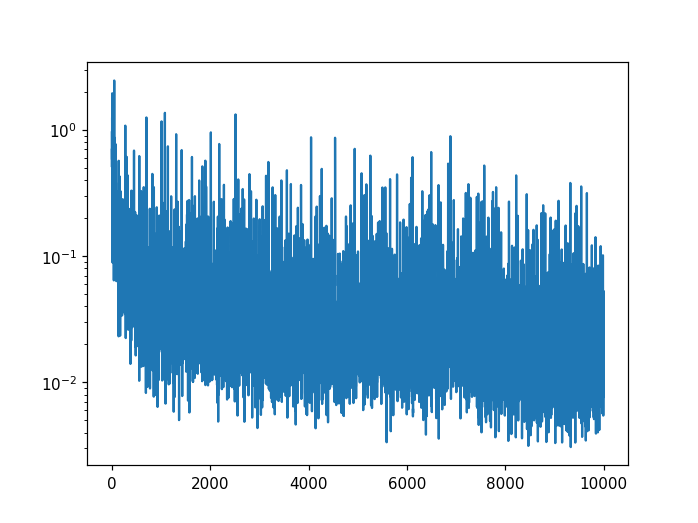

In [71]:
plt.figure()
plt.plot(iteration_vector,loss_vector)
plt.yscale('log')

<IPython.core.display.Javascript object>


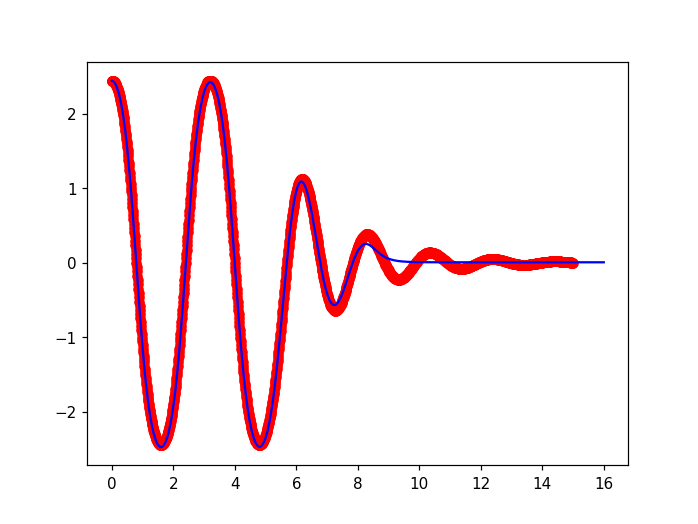

In [72]:
plt.figure()
t_data_domain = torch.linspace(0, 16, steps=1000).view(-1, 1)
with torch.no_grad():
    f_prediction = PINN(t_data_domain).numpy()
    

plt.plot(t_boundary.detach().numpy(),f_boundary.detach().numpy(),'or')
plt.plot(t_data_domain,f_prediction,'b-')

<IPython.core.display.Javascript object>


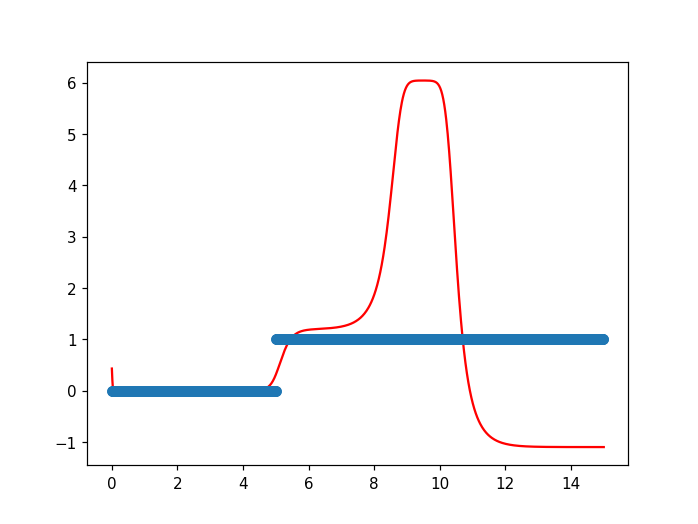

In [73]:
plt.figure()
# NOw interrogate the R approximator
t_data_domain = torch.linspace(0, 15, steps=1000).view(-1, 1)
with torch.no_grad():
    r_prediction = F_approx(t_data_domain).numpy()

plt.plot(t_data_domain,r_prediction,'r')
plt.plot( simulator.data._time, simulator.data._tvp.flatten(),'o')